<a href="https://colab.research.google.com/github/longnguyendevone/Project1/blob/main/LongProject1_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II. Models Evaluation

In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [ ]:
# Loading & Checking Dataset
# Mount Google Drive to access files if it's not already mounted
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/From/data.csv", sep = ';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Replacing whitesapce present in the column name
data.columns = [x.replace(' ', '_') for x in data.columns]
data.head()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance\t,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,...,Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Feature Selection

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit and transform the Target column
data['Target_Encoded'] = le.fit_transform(data['Target'])

# Display the mapping to understand what number represents what class
print("Target Variable Mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name} : {i}")

Target Variable Mapping:
  Dropout : 0
  Enrolled : 1
  Graduate : 2


## Outlier Handling

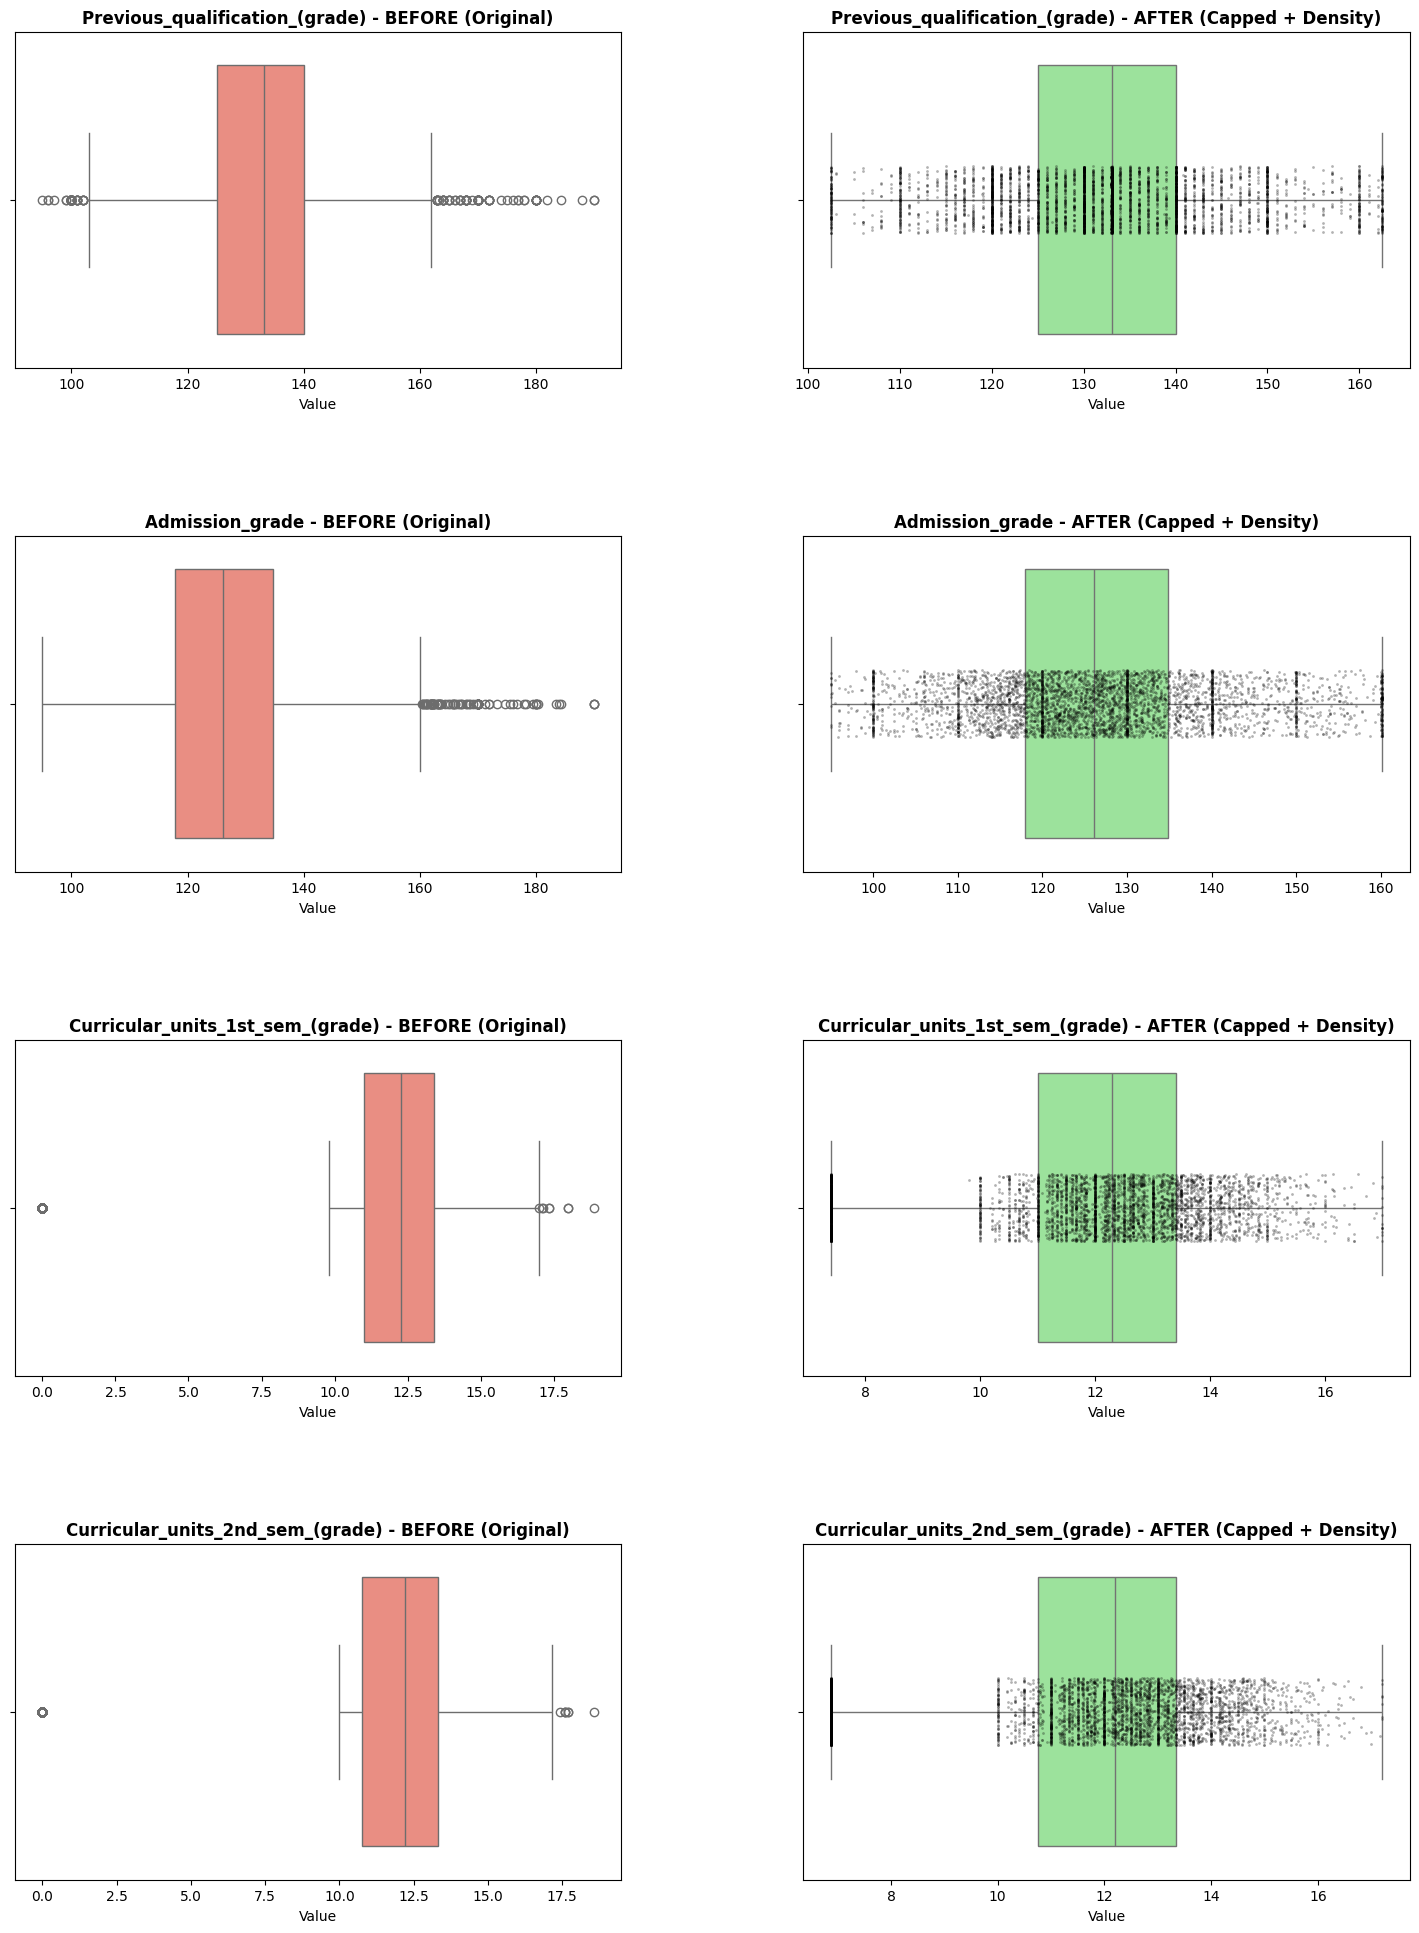

In [ ]:
# --- BLOCK 2: OUTLIER HANDLING & VISUALIZATION (Modified) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Identify Continuous Numerical Columns
continuous_cols = [
    'Previous_qualification_(grade)',
    'Admission_grade',
    'Curricular_units_1st_sem_(grade)',
    'Curricular_units_2nd_sem_(grade)'
]

# 2. Setup Plotting Area
# We increase the figure width to accommodate the side-by-side horizontal plots
n_features = len(continuous_cols)
fig, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(18, 6 * n_features))
plt.subplots_adjust(hspace=0.5, wspace=0.3) # Add spacing between rows/cols

# 3. Processing Loop
for i, col in enumerate(continuous_cols):

    # --- PLOT BEFORE (Horizontal) ---
    # Mapping to 'x' automatically orients the boxplot horizontally
    sns.boxplot(x=data[col], ax=axes[i, 0], color='salmon')
    axes[i, 0].set_title(f'{col} - BEFORE (Original)', fontsize=12, fontweight='bold')
    axes[i, 0].set_xlabel('Value')

    # --- CALCULATE IQR & CAP ---
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply Winsorization (Capping)
    # Any value < lower_bound becomes lower_bound
    # Any value > upper_bound becomes upper_bound
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

    # --- PLOT AFTER (Horizontal + Datapoints) ---
    # 1. Draw the boxplot (hide outliers since we want to draw them manually with stripplot)
    sns.boxplot(x=data[col], ax=axes[i, 1], color='lightgreen', showfliers=False)

    # 2. Overlay actual data points using stripplot
    # This shows the "piled up" data at the caps (the former outliers)
    sns.stripplot(x=data[col], ax=axes[i, 1], color='black', alpha=0.3, jitter=True, size=2)

    axes[i, 1].set_title(f'{col} - AFTER (Capped + Density)', fontsize=12, fontweight='bold')
    axes[i, 1].set_xlabel('Value')

plt.show()

## Chi-Squared Feature Selector

In [ ]:
from sklearn.feature_selection import chi2
import pandas as pd
import numpy as np

def chi_square_feature_selector(dataframe, feature_cols, target_col, significance_level=0.05):
    """
Input:
        dataframe (pd.DataFrame): The input DataFrame.
        feature_cols (list): A list of column names to be tested as features.
        target_col (str): The name of the target column.
        significance_level (float): The significance level (alpha) for the test.
Output:
        tuple: A tuple containing:
            - list: A list of feature names whose p-value is >= significance_level,
                    indicating they should be considered for dropping.
            - pd.DataFrame: A DataFrame summarizing the Chi-Square test results
                            for all features, including F-score, P-value, and
                            a 'Dropped' indicator.
    """
    X = dataframe[feature_cols]
    y = dataframe[target_col]

    # Ensure all features in X are non-negative for chi2 test
    X = np.maximum(0, X)

    # Apply the chi2 test
    f_score, p_values = chi2(X, y)

    # Create a pandas Series for p-values with feature names as index
    p_value_series = pd.Series(p_values, index=feature_cols)
    f_score_series = pd.Series(f_score, index=feature_cols)

    # Create a DataFrame for results
    results_df = pd.DataFrame({
        'Feature': feature_cols,
        'F-Score': f_score_series.values,
        'P-Value': p_value_series.values
    })

    # Sort by P-Value
    results_df = results_df.sort_values(by='P-Value', ascending=True).reset_index(drop=True)

    # Identify non-significant features and add 'Dropped' column
    non_significant_features = []
    dropped_status = []
    for feature in results_df['Feature']:
        p_val = results_df[results_df['Feature'] == feature]['P-Value'].iloc[0]
        if p_val >= significance_level:
            non_significant_features.append(feature)
            dropped_status.append(True)
        else:
            dropped_status.append(False)

    results_df['Dropped'] = dropped_status

    return non_significant_features, results_df

print("DONE.")

DONE.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Re-load the dataset and perform initial preprocessing steps để tránh bị các bước trước đè

data = pd.read_csv("/content/drive/MyDrive/From/data.csv", sep = ';')
data.columns = [x.replace(' ', '_') for x in data.columns]
le = LabelEncoder()
data['Target_Encoded'] = le.fit_transform(data['Target'])
continuous_cols = [
    'Previous_qualification_(grade)',
    'Admission_grade',
    'Curricular_units_1st_sem_(grade)',
    'Curricular_units_2nd_sem_(grade)'
]

for col in continuous_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

feature_cols = [
 'Marital_status',
 'Application_mode',
 'Application_order',
 'Course',
 'Daytime/evening_attendance\t',
 'Previous_qualification',
 'Previous_qualification_(grade)',
 'Nacionality',
 "Mother's_qualification",
 "Father's_qualification",
 "Mother's_occupation",
 "Father's_occupation",
 'Educational_special_needs',
 'Displaced',
 'International',
 'Gender',
 'Scholarship_holder',
 'Debtor',
 'Tuition_fees_up_to_date',
 'Age_at_enrollment',
 'Unemployment_rate',
 'Inflation_rate',
 'GDP',
 'Curricular_units_1st_sem_(credited)',
 'Curricular_units_1st_sem_(enrolled)',
 'Curricular_units_1st_sem_(evaluations)',
 'Curricular_units_1st_sem_(approved)',
 'Curricular_units_1st_sem_(grade)',
 'Curricular_units_1st_sem_(without_evaluations)',
 'Curricular_units_2nd_sem_(credited)',
 'Curricular_units_2nd_sem_(enrolled)',
 'Curricular_units_2nd_sem_(evaluations)',
 'Curricular_units_2nd_sem_(approved)',
 'Curricular_units_2nd_sem_(grade)',
 'Curricular_units_2nd_sem_(without_evaluations)',
 'Admission_grade'
]

target_col = 'Target_Encoded'

# Identify non-significant features and get the detailed results table
non_significant_features_to_drop, chi_square_results_table = chi_square_feature_selector(data, feature_cols, target_col)

print("\n--- Chi-Square Feature Selection Results ---")
display(chi_square_results_table)

print("\nFeatures identified for dropping due to non-significance (P-Value >= 0.05):")
print(non_significant_features_to_drop)

# Drop the identified non-significant features from the DataFrame
data.drop(labels=non_significant_features_to_drop, axis=1, inplace=True)

# Drop the original 'Target' column
data.drop(columns=['Target'], inplace=True)

# Rename 'Target_Encoded' to 'Target'
data.rename(columns={'Target_Encoded': 'Target'}, inplace=True)

# Display the first few rows of the modified DataFrame
print("\nDataFrame head after dropping non-significant features and re-targeting:")
data.head()


--- Chi-Square Feature Selection Results ---


,Feature,F-Score,P-Value,Dropped
0,Application_mode,3567.944852,0.000000e+00,False
1,Course,2566.498834,0.000000e+00,False
2,Curricular_units_1st_sem_(approved),2519.752869,0.000000e+00,False
3,Curricular_units_2nd_sem_(approved),3530.526536,0.000000e+00,False
4,Mother's_occupation,1247.907383,1.047984e-271,False
5,Father's_occupation,1033.829580,3.211879e-225,False
6,Curricular_units_2nd_sem_(grade),922.943628,3.848909e-201,False
7,Age_at_enrollment,715.976606,3.370198e-156,False
8,Curricular_units_1st_sem_(grade),523.653633,1.950106e-114,False
9,Curricular_units_2nd_sem_(evaluations),326.618731,1.190265e-71,False



Features identified for dropping due to non-significance (P-Value >= 0.05):
['Inflation_rate', 'Daytime/evening_attendance\t', 'International', 'Educational_special_needs']

DataFrame head after dropping non-significant features and re-targeting:


,Marital_status,Application_mode,Application_order,Course,Previous_qualification,Previous_qualification_(grade),Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,...,Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,GDP,Target
0,1,17,5,171,1,122.0,1,19,12,5,...,0,0,0,0,0,6.875000,0,10.8,1.74,0
1,1,15,1,9254,1,160.0,1,1,3,3,...,0,0,6,6,6,13.666667,0,13.9,0.79,2
2,1,1,5,9070,1,122.0,1,37,37,9,...,0,0,6,0,0,6.875000,0,10.8,1.74,0
3,1,17,2,9773,1,122.0,1,38,37,5,...,0,0,6,10,5,12.400000,0,9.4,-3.12,2
4,2,39,1,8014,1,102.5,1,37,38,9,...,0,0,6,6,6,13.000000,0,13.9,0.79,2


## Model Testing

In [ ]:
data.drop(['Previous_qualification_(grade)', 'Admission_grade','Curricular_units_1st_sem_(grade)',
           'Curricular_units_2nd_sem_(grade)'], axis = 1, inplace = True)

Ngăn chặn rò rỉ thông tin: Mục tiêu của dự án là nhận diện sinh viên có nguy cơ bỏ học ở "giai đoạn sớm". Việc đưa các cột điểm kết thúc học kỳ 1 và học kỳ 2 vào sẽ khiến mô hình biết trước kết quả của tương lai. Nếu muốn dự đoán ngay từ khi sinh viên mới nhập học hoặc trong thời gian đầu, việc sử dụng những điểm số này sẽ bị coi là "rò rỉ" dữ liệu vì chúng chưa hề tồn tại ở thời điểm dự đoán đó.

Giảm thiểu hiện tượng đa cộng tuyến (Multicollinearity): Tập dữ liệu chứa nhiều cột liên quan mật thiết đến điểm số (điểm học tập trước đó, điểm nhập học, điểm kỳ 1, điểm kỳ 2). Các biến này thường có sự tương quan rất cao với nhau. Việc giữ lại tất cả có thể dẫn đến hiện tượng đa cộng tuyến, làm mất ổn định các mô hình học máy và khiến việc xác định mức độ ảnh hưởng độc lập của từng đặc trưng trở nên khó khăn.

Tập trung vào các yếu tố trước khi nhập học: Mô tả tập dữ liệu nhấn mạnh vào việc bao gồm "thông tin được biết tại thời điểm sinh viên nhập học – lộ trình học vấn, mô hình nhân khẩu và các yếu tố kinh tế - xã hội". Việc loại bỏ điểm số các học kỳ giúp bộ dữ liệu tập trung chính xác hơn vào các yếu tố nền tảng ban đầu này.

In [ ]:
data.head()

,Marital_status,Application_mode,Application_order,Course,Previous_qualification,Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,...,Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,GDP,Target
0,1,17,5,171,1,1,19,12,5,9,...,0,0,0,0,0,0,0,10.8,1.74,0
1,1,15,1,9254,1,1,1,3,3,3,...,6,0,0,6,6,6,0,13.9,0.79,2
2,1,1,5,9070,1,1,37,37,9,9,...,0,0,0,6,0,0,0,10.8,1.74,0
3,1,17,2,9773,1,1,38,37,5,3,...,6,0,0,6,10,5,0,9.4,-3.12,2
4,2,39,1,8014,1,1,37,38,9,9,...,5,0,0,6,6,6,0,13.9,0.79,2


## SMOTE-NC

In [ ]:
try:
    from imblearn.over_sampling import SMOTENC
except ImportError:
    %pip install imbalanced-learn
    from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

# Define X (features) and y (target) from the 'data' DataFrame
X = data.drop('Target', axis=1)
y = data['Target']

# 2. Identify Numerical and Categorical Features in X
# Based on the data, some columns are numerical and others are categorical (even if stored as int64), explicitly define numerical columns for SMOTE-NC, as these will NOT be in categorical_features
numerical_cols_for_smotenc = [
    'Age_at_enrollment',
    'Unemployment_rate',
    'GDP',
    'Curricular_units_1st_sem_(credited)',
    'Curricular_units_1st_sem_(enrolled)',
    'Curricular_units_1st_sem_(evaluations)',
    'Curricular_units_1st_sem_(approved)',
    'Curricular_units_1st_sem_(without_evaluations)',
    'Curricular_units_2nd_sem_(credited)',
    'Curricular_units_2nd_sem_(enrolled)',
    'Curricular_units_2nd_sem_(evaluations)',
    'Curricular_units_2nd_sem_(approved)',
    'Curricular_units_2nd_sem_(without_evaluations)'
]

# Identify categorical feature indices for SMOTE-NC these are all columns in X that are NOT in numerical_cols_for_smotenc
cat_features_indices = [
    X.columns.get_loc(col) for col in X.columns
    if col not in numerical_cols_for_smotenc
]

# 3. Split Data open ma legs bon appetit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original Training Shape: {X_train.shape}")
print(f"Class Distribution before SMOTE:\n{y_train.value_counts()}")
print(f"Categorical feature indices for SMOTE-NC: {cat_features_indices}")

# 4. Apply SMOTE-NC
# sampling_strategy='auto' resamples all classes to match the majority class count
smote_nc = SMOTENC(categorical_features=cat_features_indices, random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

#ĐỔI THÀNH X_train so system won't complain và các model cứ thế mà dùng X_train...
X_train = X_train_resampled
y_train = y_train_resampled

print("-" * 30)
print(f"Final Training Shape (After SMOTE): {X_train.shape}")
print(f"Class Distribution after SMOTE:\n{y_train.value_counts()}")

Original Training Shape: (3539, 28)
Class Distribution before SMOTE:
Target
2    1767
0    1137
1     635
Name: count, dtype: int64
Categorical feature indices for SMOTE-NC: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
------------------------------
Final Training Shape (After SMOTE): (5301, 28)
Class Distribution after SMOTE:
Target
2    1767
0    1767
1    1767
Name: count, dtype: int64


In [ ]:
!pip install catboost lightgbm xgboost -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin

#Hàm Evaluate for all
def evaluate_model(model, X_test, y_test, model_name, is_hand_coded=False):
    """
    Plots confusion matrix and prints classification report.
    Returns accuracy score.
    """
    print(f"\n{'='*10} {model_name} {'='*10}")

    # Predict
    try:
        if is_hand_coded and hasattr(model, 'predict_proba'):
            # Some hand-coded models might need specific handling
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test)
    except Exception as e:
        # Fallback for numpy/pandas mismatches in custom code
        y_pred = model.predict(X_test.values if hasattr(X_test, 'values') else X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return acc

In [ ]:
from sklearn.preprocessing import StandardScaler

#Đã làm sẵn X_train và y_train và SMOTE ở trên nên chỉ gọi lại thôi
#THÊM VÀO LÀ LỖI ĐÓ

# 1. Scale Data
#Naive Bayes cần cái này, cả kNN nữa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Prepared and Scaled (using SMOTE-NC data for training set):")
print(f"Training Scaled Shape: {X_train_scaled.shape}")
print(f"Testing Scaled Shape:  {X_test_scaled.shape}")

Data Prepared and Scaled (using SMOTE-NC data for training set):
Training Scaled Shape: (5301, 28)
Testing Scaled Shape:  (885, 28)


## S sanh dứa handcoded và có sẵn

Training Hand-Coded Naive Bayes...

========== Hand-Coded Naive Bayes ==========
Accuracy: 57.40%
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       284
           1       0.26      0.50      0.34       159
           2       0.79      0.56      0.66       442

    accuracy                           0.57       885
   macro avg       0.58      0.57      0.55       885
weighted avg       0.66      0.57      0.60       885



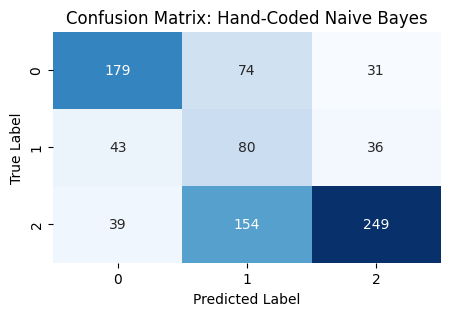

Training Library Naive Bayes...

========== Library Naive Bayes ==========
Accuracy: 57.40%
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       284
           1       0.26      0.51      0.34       159
           2       0.79      0.56      0.66       442

    accuracy                           0.57       885
   macro avg       0.58      0.57      0.55       885
weighted avg       0.66      0.57      0.60       885



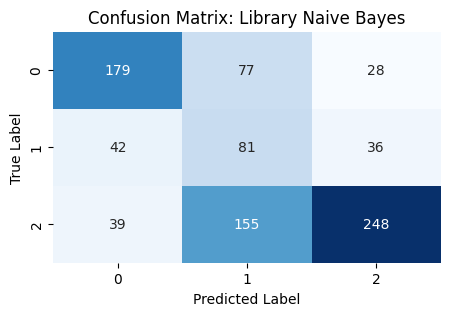

Training Hand-Coded Decision Tree...

========== Hand-Coded Decision Tree ==========
Accuracy: 66.44%
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       284
           1       0.33      0.60      0.43       159
           2       0.83      0.68      0.74       442

    accuracy                           0.66       885
   macro avg       0.66      0.65      0.64       885
weighted avg       0.74      0.66      0.69       885



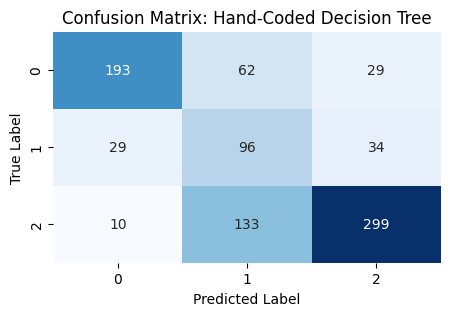

Training Library Decision Tree...

========== Library Decision Tree ==========
Accuracy: 73.45%
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       284
           1       0.44      0.62      0.51       159
           2       0.83      0.85      0.84       442

    accuracy                           0.73       885
   macro avg       0.71      0.70      0.69       885
weighted avg       0.77      0.73      0.74       885



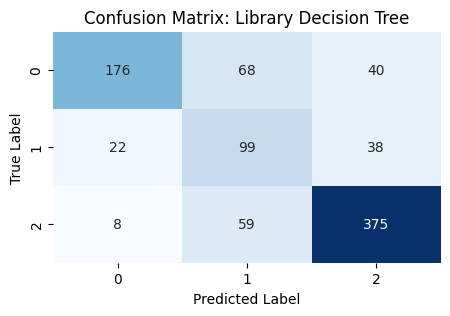

Training Hand-Coded Random Forest...

========== Hand-Coded Random Forest ==========
Accuracy: 73.11%
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       284
           1       0.42      0.64      0.51       159
           2       0.84      0.83      0.83       442

    accuracy                           0.73       885
   macro avg       0.71      0.70      0.69       885
weighted avg       0.77      0.73      0.74       885



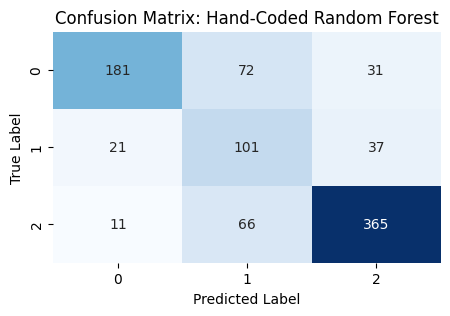

Training Library Random Forest...

========== Library Random Forest ==========
Accuracy: 73.45%
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       284
           1       0.45      0.48      0.46       159
           2       0.81      0.83      0.82       442

    accuracy                           0.73       885
   macro avg       0.68      0.68      0.68       885
weighted avg       0.74      0.73      0.74       885



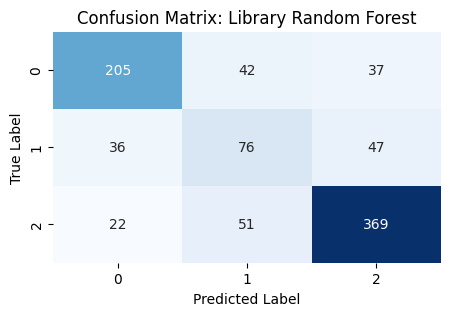

Training Hand-Coded XGBoost...

========== Hand-Coded XGBoost ==========
Accuracy: 59.21%
              precision    recall  f1-score   support

           0       0.91      0.57      0.70       284
           1       0.29      0.84      0.43       159
           2       0.93      0.52      0.66       442

    accuracy                           0.59       885
   macro avg       0.71      0.64      0.60       885
weighted avg       0.81      0.59      0.63       885



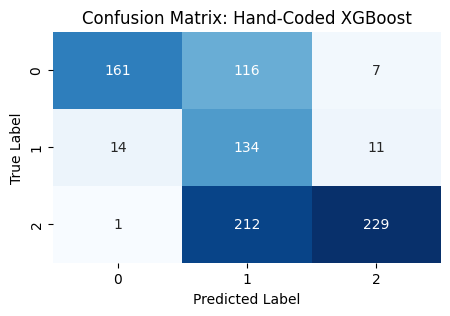

Training Library XGBoost...

========== Library XGBoost ==========
Accuracy: 75.48%
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       284
           1       0.47      0.62      0.54       159
           2       0.84      0.86      0.85       442

    accuracy                           0.75       885
   macro avg       0.72      0.72      0.71       885
weighted avg       0.78      0.75      0.76       885



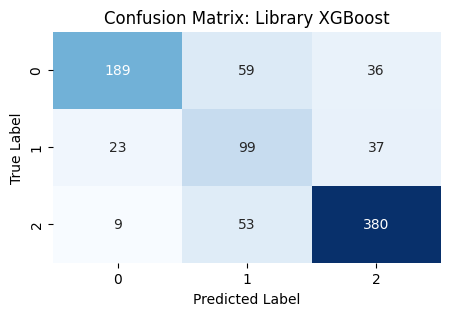

Training Hand-Coded CatBoost...

========== Hand-Coded CatBoost ==========
Accuracy: 59.21%
              precision    recall  f1-score   support

           0       0.91      0.57      0.70       284
           1       0.29      0.84      0.43       159
           2       0.93      0.52      0.66       442

    accuracy                           0.59       885
   macro avg       0.71      0.64      0.60       885
weighted avg       0.81      0.59      0.63       885



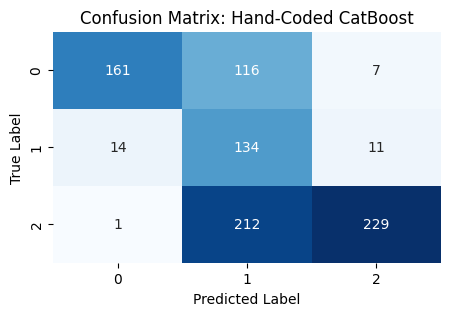

Training Library CatBoost...

========== Library CatBoost ==========
Accuracy: 73.67%
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       284
           1       0.42      0.53      0.47       159
           2       0.84      0.83      0.83       442

    accuracy                           0.74       885
   macro avg       0.69      0.69      0.69       885
weighted avg       0.76      0.74      0.74       885



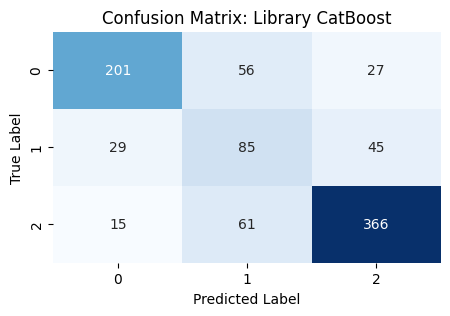

Training Hand-Coded LightGBM...

========== Hand-Coded LightGBM ==========
Accuracy: 59.21%
              precision    recall  f1-score   support

           0       0.91      0.57      0.70       284
           1       0.29      0.84      0.43       159
           2       0.93      0.52      0.66       442

    accuracy                           0.59       885
   macro avg       0.71      0.64      0.60       885
weighted avg       0.81      0.59      0.63       885



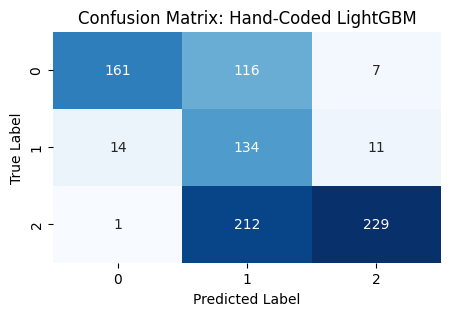

Training Library LightGBM...

========== Library LightGBM ==========
Accuracy: 75.14%
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       284
           1       0.46      0.58      0.52       159
           2       0.85      0.84      0.85       442

    accuracy                           0.75       885
   macro avg       0.71      0.71      0.71       885
weighted avg       0.77      0.75      0.76       885



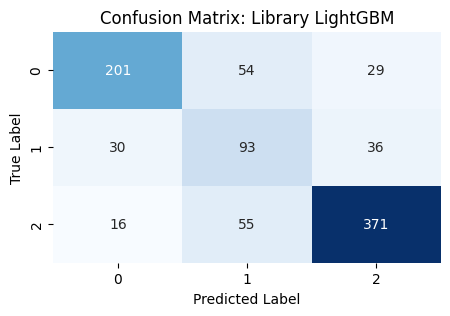

In [ ]:
from scipy.stats import mode
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#Naive Bayes tự làm
class CustomNaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        self._mean = np.zeros((len(self._classes), n_features))
        self._var = np.zeros((len(self._classes), n_features))
        self._priors = np.zeros(len(self._classes))

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, x):
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posteriors.append(prior + class_conditional)
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        return (np.exp(-(x - mean)**2 / (2 * var))) / (np.sqrt(2 * np.pi * var))
# DECISION TREE CAN GO DIE IN A DITCH
class CustomDecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        # Build the tree
        self.n_classes_ = len(np.unique(y))
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria: Max depth, pure node, or too few samples
        if depth >= self.max_depth or n_labels == 1 or n_samples < 2:
            return mode(y, keepdims=True)[0][0]

        feat_idxs = np.random.choice(n_feats, n_feats, replace=False)
        best_feat, best_thresh = None, None
        best_gini = 1.0

        # Greedy Search for Best Split
        for feat_idx in feat_idxs:
            thresholds = np.unique(X[:, feat_idx])
            # Optimization: check max 10 thresholds per feature to save time
            if len(thresholds) > 10: thresholds = np.random.choice(thresholds, 10, replace=False)

            for thresh in thresholds:
                left_idx = X[:, feat_idx] < thresh
                if np.sum(left_idx) == 0 or np.sum(~left_idx) == 0: continue

                # Gini Impurity Calculation
                gini = (np.sum(left_idx)*self._gini(y[left_idx]) + np.sum(~left_idx)*self._gini(y[~left_idx])) / n_samples

                if gini < best_gini:
                    best_gini = gini
                    best_feat = feat_idx
                    best_thresh = thresh

        if best_feat is None: return mode(y, keepdims=True)[0][0]

        # Recursive Split
        left_idx = X[:, best_feat] < best_thresh
        left_child = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right_child = self._grow_tree(X[~left_idx], y[~left_idx], depth + 1)
        return (best_feat, best_thresh, left_child, right_child)

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs**2)

    def predict(self, X):
        return np.array([self._traverse(x, self.tree) for x in X])

    def _traverse(self, x, node):
        if not isinstance(node, tuple): return node
        feat, thresh, left, right = node
        if x[feat] < thresh: return self._traverse(x, left)
        else: return self._traverse(x, right)

# Random Forest tự làm (Bagging)
class CustomRandomForest:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.trees = []
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            idx = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTreeClassifier(max_depth=8) # Weak learner
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return mode(preds, axis=0, keepdims=True)[0][0]

# Gradient Boosting so sánh với 3 cái còn lại
class CustomGBM:
    def __init__(self, n_estimators=20, lr=0.1):
        self.n_estimators = n_estimators
        self.lr = lr
        self.models = []
        self.base_pred = 0
    def fit(self, X, y):
        # Simplification: Treating as Regression on Residuals
        self.base_pred = np.mean(y)
        curr_pred = np.full(len(y), self.base_pred)
        for _ in range(self.n_estimators):
            residuals = y - curr_pred
            tree = DecisionTreeRegressor(max_depth=3) # Weak Regressor
            tree.fit(X, residuals)
            self.models.append(tree)
            curr_pred += self.lr * tree.predict(X)
    def predict(self, X):
        pred = np.full(len(X), self.base_pred)
        for tree in self.models:
            pred += self.lr * tree.predict(X)
        return np.round(pred).astype(int)

#CHUYỂN THÀNH NUMPY để chạy các tự làm
X_tr_np, y_tr_np = X_train.values, y_train.values
X_te_np, y_te_np = X_test.values, y_test.values

models = [
    ("Naive Bayes", CustomNaiveBayes(), GaussianNB()),
#Chúa ơi cuối cùng cũng xong decisiontree
    ("Decision Tree", CustomDecisionTree(max_depth=5), DecisionTreeClassifier(max_depth=5)),
    ("Random Forest", CustomRandomForest(n_estimators=15), RandomForestClassifier(n_estimators=15)),
    ("XGBoost", CustomGBM(n_estimators=20), XGBClassifier(n_estimators=20, use_label_encoder=False, eval_metric='logloss')),
    ("CatBoost", CustomGBM(n_estimators=20), CatBoostClassifier(n_estimators=20, verbose=0)),
    ("LightGBM", CustomGBM(n_estimators=20), LGBMClassifier(n_estimators=20, verbose=-1))
]

results = {'Model': [], 'Score': [], 'Type': []}

for name, custom, lib in models:
    # Custom
    print(f"Training Hand-Coded {name}...")
    custom.fit(X_tr_np, y_tr_np)
    acc_c = evaluate_model(custom, X_te_np, y_te_np, f"Hand-Coded {name}", True)

    # Library
    print(f"Training Library {name}...")
    lib.fit(X_train, y_train)
    acc_l = evaluate_model(lib, X_test, y_test, f"Library {name}", False)

    results['Model'].extend([name, name])
    results['Score'].extend([acc_c, acc_l])
    results['Type'].extend(['Hand-Coded', 'Library'])

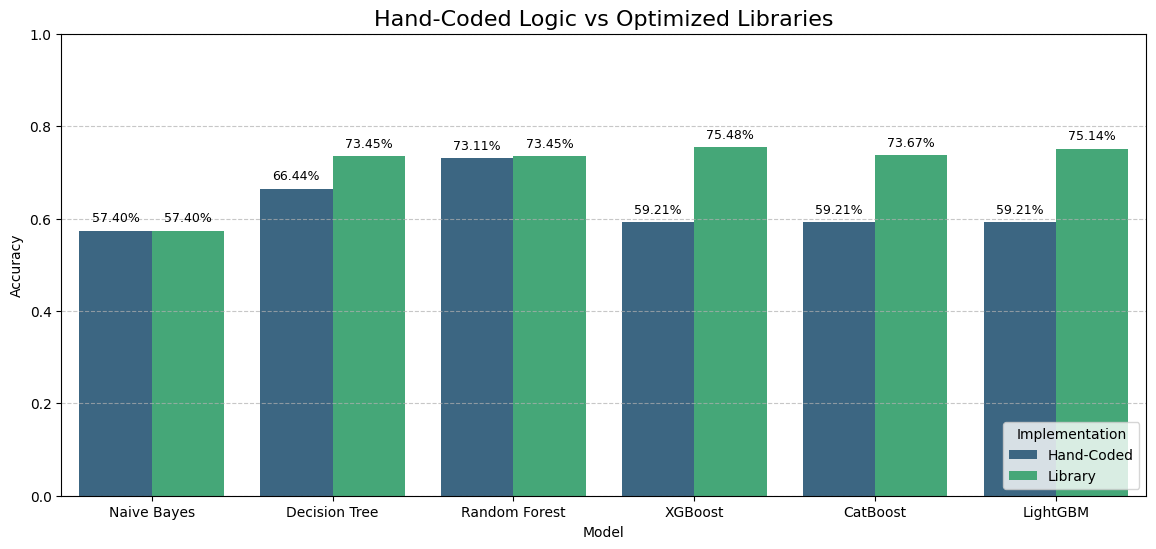

In [ ]:
#Vẽ bảng
results_df = pd.DataFrame(results)

plt.figure(figsize=(14, 6))
sns.barplot(data=results_df, x='Model', y='Score', hue='Type', palette='viridis')

plt.title('Hand-Coded Logic vs Optimized Libraries', fontsize=16)
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right', title='Implementation')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.2%}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 9),
                           textcoords='offset points', fontsize=9)

plt.show()